# Using LSTM

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as ag
from torch.utils.data import DataLoader, Dataset

torch.manual_seed(1)

In [84]:
INPUT_DIM = 60
HIDDEN_DIM = 70
SEQ_LENGTH = 501
LABEL_COUNT = 15

MINIBATCH_SIZE = 117

class SoundSequenceDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        assert(X.shape[0] == Y.shape[0])
        
    def __len__(self):
        return self.Y.shape[0]
    
    def __getitem__(self, index):
        return self.X[index,:,:], self.Y[index]

In [73]:
import numpy as np
x1 = np.load('fold_arrays/fold1_x.npy')
y1 = np.load('fold_arrays/fold1_y.npy')

x2 = np.load('fold_arrays/fold2_x.npy')
y2 = np.load('fold_arrays/fold2_y.npy')

x3 = np.load('fold_arrays/fold3_x.npy')
y3 = np.load('fold_arrays/fold3_y.npy')

x4 = np.load('fold_arrays/fold4_x.npy')
y4 = np.load('fold_arrays/fold4_y.npy')

x = np.append(x1, x2[:1170,:,:], axis=0)
x = np.append(x, x3[:1170,:,:], axis=0)

y = np.append(y1, y2[:1170], axis=0)
y = np.append(y, y3[:1170], axis=0)

train_loader = DataLoader(dataset=SoundSequenceDataset(x, y),
                        batch_size=MINIBATCH_SIZE, 
                        shuffle=True)
test_loader = DataLoader(dataset=SoundSequenceDataset(x4, y4),
                        batch_size=MINIBATCH_SIZE,
                        shuffle=False)


In [85]:
# Create the LSTM model
class LstmPredictor(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_size, n_layers=1):
        super(LstmPredictor, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=n_layers, batch_first=True, dropout=0.5)

        # The linear layer that maps from hidden state space to environment label space
        self.hidden2label = nn.Linear(hidden_dim, output_size)
        
    def forward(self, audio_segments):
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        h0 = torch.zeros(self.n_layers, MINIBATCH_SIZE, self.hidden_dim) 
        c0 = torch.zeros(self.n_layers, MINIBATCH_SIZE, self.hidden_dim)
        
        lstm_out, _ = self.lstm(audio_segments, (h0, c0))
            #embeds.view(len(audio_segment), 1, -1), self.hidden)
        label_softmax = self.hidden2label(lstm_out[:, -1, :]) #self.hidden[0])
        #segment_scores = F.log_softmax(label_space, dim=1)
        return label_softmax #segment_scores

torch.Size([117, 501, 60])
torch.Size([117, 501, 60])
torch.Size([117, 501, 60])
torch.Size([117, 501, 60])
torch.Size([117, 501, 60])
torch.Size([117, 501, 60])
torch.Size([117, 501, 60])
torch.Size([117, 501, 60])
torch.Size([117, 501, 60])
torch.Size([117, 501, 60])


In [86]:
model = LstmPredictor(INPUT_DIM, HIDDEN_DIM, LABEL_COUNT, n_layers=1)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
acc_train = []
acc_test = []

def train_model(epochs):
    for epoch in range(epochs):  # again, normally you would NOT do 300 epochs, it is toy data
        print("Epoch", epoch)
        predicted_count = 0
        for i, (x, y) in enumerate(train_loader):
            #model.zero_grad()

            # Step 2. Get our inputs ready for the network, that is, turn them into
            # Tensors of word indices.
            #seq = x.reshape(MINIBATCH_SIZE, SEQ_LENGTH, INPUT_DIM)
            #sentence_in = prepare_sequence(sentence, word_to_ix)
            #targets = prepare_sequence(tags, tag_to_ix)

            # Step 3. Run our forward pass.
            pred_y = model(torch.tensor(x, dtype=torch.float))
            loss = loss_function(pred_y, ag.Variable(y.long()))
            
            # Step 4. Compute the loss, gradients, and update the parameters by
            #  calling optimizer.step()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            _, pred = torch.max(pred_y.data, 1) 
            pred_batch = (pred == y.long()).sum().item()
            predicted_count += pred_batch 
            print("Batch", i, "Acc/batch:", float(pred_batch) / MINIBATCH_SIZE)
        
        acc = float(predicted_count) / (MINIBATCH_SIZE * len(train_loader))
        acc_train.append(acc)
        print("Training acc for epoch:", acc)
        
        with torch.no_grad():
            correct = 0
            for (x, y) in test_loader:
                pred_test = model(torch.tensor(x, dtype=torch.float))
                _, pred = torch.max(pred_test.data, 1) 
                pred_batch = (pred == y.long()).sum().item()
                correct += pred_batch
            acc = float(correct) / (len(test_loader) * MINIBATCH_SIZE)
            print("Test acc for epoch:", acc)
            acc_test.append(acc)
            
train_model(10)

# See what the scores are after training
#with torch.no_grad():
#    inputs = prepare_sequence(training_data[0][0], word_to_ix)
#    tag_scores = model(inputs)

    # The sentence is "the dog ate the apple".  i,j corresponds to score for tag j
    # for word i. The predicted tag is the maximum scoring tag.
    # Here, we can see the predicted sequence below is 0 1 2 0 1
    # since 0 is index of the maximum value of row 1,
    # 1 is the index of maximum value of row 2, etc.
    # Which is DET NOUN VERB DET NOUN, the correct sequence!
#    print(tag_scores)

C:\Tools\Anaconda2\envs\pt36\lib\site-packages\torch\nn\modules\rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch 0
Batch 0 Acc/batch: 0.05128205128205128
Batch 1 Acc/batch: 0.05982905982905983
Batch 2 Acc/batch: 0.07692307692307693
Batch 3 Acc/batch: 0.1111111111111111
Batch 4 Acc/batch: 0.05128205128205128
Batch 5 Acc/batch: 0.05982905982905983
Batch 6 Acc/batch: 0.1111111111111111
Batch 7 Acc/batch: 0.17094017094017094
Batch 8 Acc/batch: 0.17094017094017094
Batch 9 Acc/batch: 0.1794871794871795
Batch 10 Acc/batch: 0.13675213675213677
Batch 11 Acc/batch: 0.10256410256410256
Batch 12 Acc/batch: 0.07692307692307693
Batch 13 Acc/batch: 0.1282051282051282
Batch 14 Acc/batch: 0.15384615384615385
Batch 15 Acc/batch: 0.21367521367521367
Batch 16 Acc/batch: 0.23076923076923078
Batch 17 Acc/batch: 0.2222222222222222
Batch 18 Acc/batch: 0.2564102564102564
Batch 19 Acc/batch: 0.23076923076923078
Batch 20 Acc/batch: 0.24786324786324787
Batch 21 Acc/batch: 0.2564102564102564
Batch 22 Acc/batch: 0.2222222222222222
Batch 23 Acc/batch: 0.24786324786324787
Batch 24 Acc/batch: 0.24786324786324787
Batch 25 A

Batch 16 Acc/batch: 0.49572649572649574
Batch 17 Acc/batch: 0.5470085470085471
Batch 18 Acc/batch: 0.48717948717948717
Batch 19 Acc/batch: 0.46153846153846156
Batch 20 Acc/batch: 0.46153846153846156
Batch 21 Acc/batch: 0.4358974358974359
Batch 22 Acc/batch: 0.4700854700854701
Batch 23 Acc/batch: 0.46153846153846156
Batch 24 Acc/batch: 0.4700854700854701
Batch 25 Acc/batch: 0.42735042735042733
Batch 26 Acc/batch: 0.452991452991453
Batch 27 Acc/batch: 0.42735042735042733
Batch 28 Acc/batch: 0.42735042735042733
Batch 29 Acc/batch: 0.46153846153846156
Training acc for epoch: 0.4723646723646724
Test acc for epoch: 0.46068376068376066
Epoch 7
Batch 0 Acc/batch: 0.4700854700854701
Batch 1 Acc/batch: 0.49572649572649574
Batch 2 Acc/batch: 0.5726495726495726
Batch 3 Acc/batch: 0.5299145299145299
Batch 4 Acc/batch: 0.49572649572649574
Batch 5 Acc/batch: 0.5213675213675214
Batch 6 Acc/batch: 0.4700854700854701
Batch 7 Acc/batch: 0.5128205128205128
Batch 8 Acc/batch: 0.5042735042735043
Batch 9 Acc

In [87]:
train_model(40)

Epoch 0
Batch 0 Acc/batch: 0.452991452991453
Batch 1 Acc/batch: 0.5555555555555556
Batch 2 Acc/batch: 0.6068376068376068
Batch 3 Acc/batch: 0.6068376068376068
Batch 4 Acc/batch: 0.5299145299145299
Batch 5 Acc/batch: 0.5555555555555556
Batch 6 Acc/batch: 0.6581196581196581
Batch 7 Acc/batch: 0.6239316239316239
Batch 8 Acc/batch: 0.5299145299145299
Batch 9 Acc/batch: 0.6153846153846154
Batch 10 Acc/batch: 0.5299145299145299
Batch 11 Acc/batch: 0.5299145299145299
Batch 12 Acc/batch: 0.6324786324786325
Batch 13 Acc/batch: 0.5982905982905983
Batch 14 Acc/batch: 0.5213675213675214
Batch 15 Acc/batch: 0.42735042735042733
Batch 16 Acc/batch: 0.49572649572649574
Batch 17 Acc/batch: 0.5726495726495726
Batch 18 Acc/batch: 0.49572649572649574
Batch 19 Acc/batch: 0.5470085470085471
Batch 20 Acc/batch: 0.5897435897435898
Batch 21 Acc/batch: 0.5982905982905983
Batch 22 Acc/batch: 0.6068376068376068
Batch 23 Acc/batch: 0.5726495726495726
Batch 24 Acc/batch: 0.5641025641025641
Batch 25 Acc/batch: 0.461

Batch 18 Acc/batch: 0.6410256410256411
Batch 19 Acc/batch: 0.5811965811965812
Batch 20 Acc/batch: 0.5897435897435898
Batch 21 Acc/batch: 0.6239316239316239
Batch 22 Acc/batch: 0.5470085470085471
Batch 23 Acc/batch: 0.5470085470085471
Batch 24 Acc/batch: 0.5555555555555556
Batch 25 Acc/batch: 0.5982905982905983
Batch 26 Acc/batch: 0.5726495726495726
Batch 27 Acc/batch: 0.6324786324786325
Batch 28 Acc/batch: 0.5726495726495726
Batch 29 Acc/batch: 0.5384615384615384
Training acc for epoch: 0.5925925925925926
Test acc for epoch: 0.5042735042735043
Epoch 7
Batch 0 Acc/batch: 0.6410256410256411
Batch 1 Acc/batch: 0.5897435897435898
Batch 2 Acc/batch: 0.6495726495726496
Batch 3 Acc/batch: 0.5641025641025641
Batch 4 Acc/batch: 0.5299145299145299
Batch 5 Acc/batch: 0.5384615384615384
Batch 6 Acc/batch: 0.5042735042735043
Batch 7 Acc/batch: 0.5726495726495726
Batch 8 Acc/batch: 0.49572649572649574
Batch 9 Acc/batch: 0.5555555555555556
Batch 10 Acc/batch: 0.6410256410256411
Batch 11 Acc/batch: 0.

Batch 4 Acc/batch: 0.6068376068376068
Batch 5 Acc/batch: 0.6068376068376068
Batch 6 Acc/batch: 0.6153846153846154
Batch 7 Acc/batch: 0.7435897435897436
Batch 8 Acc/batch: 0.6153846153846154
Batch 9 Acc/batch: 0.6153846153846154
Batch 10 Acc/batch: 0.5982905982905983
Batch 11 Acc/batch: 0.6239316239316239
Batch 12 Acc/batch: 0.6068376068376068
Batch 13 Acc/batch: 0.5811965811965812
Batch 14 Acc/batch: 0.5213675213675214
Batch 15 Acc/batch: 0.5641025641025641
Batch 16 Acc/batch: 0.5982905982905983
Batch 17 Acc/batch: 0.6153846153846154
Batch 18 Acc/batch: 0.6239316239316239
Batch 19 Acc/batch: 0.5555555555555556
Batch 20 Acc/batch: 0.6495726495726496
Batch 21 Acc/batch: 0.5811965811965812
Batch 22 Acc/batch: 0.6324786324786325
Batch 23 Acc/batch: 0.6153846153846154
Batch 24 Acc/batch: 0.5897435897435898
Batch 25 Acc/batch: 0.5555555555555556
Batch 26 Acc/batch: 0.6239316239316239
Batch 27 Acc/batch: 0.6153846153846154
Batch 28 Acc/batch: 0.5982905982905983
Batch 29 Acc/batch: 0.529914529

Batch 22 Acc/batch: 0.6324786324786325
Batch 23 Acc/batch: 0.6239316239316239
Batch 24 Acc/batch: 0.5982905982905983
Batch 25 Acc/batch: 0.6324786324786325
Batch 26 Acc/batch: 0.6153846153846154
Batch 27 Acc/batch: 0.6410256410256411
Batch 28 Acc/batch: 0.5299145299145299
Batch 29 Acc/batch: 0.6495726495726496
Training acc for epoch: 0.6233618233618233
Test acc for epoch: 0.5470085470085471
Epoch 20
Batch 0 Acc/batch: 0.6837606837606838
Batch 1 Acc/batch: 0.6923076923076923
Batch 2 Acc/batch: 0.6324786324786325
Batch 3 Acc/batch: 0.6495726495726496
Batch 4 Acc/batch: 0.6581196581196581
Batch 5 Acc/batch: 0.5811965811965812
Batch 6 Acc/batch: 0.6666666666666666
Batch 7 Acc/batch: 0.6837606837606838
Batch 8 Acc/batch: 0.6239316239316239
Batch 9 Acc/batch: 0.6153846153846154
Batch 10 Acc/batch: 0.6495726495726496
Batch 11 Acc/batch: 0.5470085470085471
Batch 12 Acc/batch: 0.6324786324786325
Batch 13 Acc/batch: 0.6666666666666666
Batch 14 Acc/batch: 0.6324786324786325
Batch 15 Acc/batch: 0.

Batch 8 Acc/batch: 0.6495726495726496
Batch 9 Acc/batch: 0.5982905982905983
Batch 10 Acc/batch: 0.5982905982905983
Batch 11 Acc/batch: 0.5811965811965812
Batch 12 Acc/batch: 0.5982905982905983
Batch 13 Acc/batch: 0.5384615384615384
Batch 14 Acc/batch: 0.6581196581196581
Batch 15 Acc/batch: 0.5897435897435898
Batch 16 Acc/batch: 0.5897435897435898
Batch 17 Acc/batch: 0.6581196581196581
Batch 18 Acc/batch: 0.6068376068376068
Batch 19 Acc/batch: 0.5811965811965812
Batch 20 Acc/batch: 0.5897435897435898
Batch 21 Acc/batch: 0.6837606837606838
Batch 22 Acc/batch: 0.6324786324786325
Batch 23 Acc/batch: 0.5726495726495726
Batch 24 Acc/batch: 0.7008547008547008
Batch 25 Acc/batch: 0.5897435897435898
Batch 26 Acc/batch: 0.6324786324786325
Batch 27 Acc/batch: 0.5897435897435898
Batch 28 Acc/batch: 0.7008547008547008
Batch 29 Acc/batch: 0.6581196581196581
Training acc for epoch: 0.6193732193732193
Test acc for epoch: 0.558974358974359
Epoch 27
Batch 0 Acc/batch: 0.5811965811965812
Batch 1 Acc/batc

Batch 26 Acc/batch: 0.5726495726495726
Batch 27 Acc/batch: 0.7008547008547008
Batch 28 Acc/batch: 0.6666666666666666
Batch 29 Acc/batch: 0.7008547008547008
Training acc for epoch: 0.6487179487179487
Test acc for epoch: 0.564957264957265
Epoch 33
Batch 0 Acc/batch: 0.7094017094017094
Batch 1 Acc/batch: 0.6581196581196581
Batch 2 Acc/batch: 0.7094017094017094
Batch 3 Acc/batch: 0.6581196581196581
Batch 4 Acc/batch: 0.6923076923076923
Batch 5 Acc/batch: 0.6495726495726496
Batch 6 Acc/batch: 0.6410256410256411
Batch 7 Acc/batch: 0.6495726495726496
Batch 8 Acc/batch: 0.6752136752136753
Batch 9 Acc/batch: 0.7264957264957265
Batch 10 Acc/batch: 0.6495726495726496
Batch 11 Acc/batch: 0.6581196581196581
Batch 12 Acc/batch: 0.5470085470085471
Batch 13 Acc/batch: 0.6068376068376068
Batch 14 Acc/batch: 0.5982905982905983
Batch 15 Acc/batch: 0.6837606837606838
Batch 16 Acc/batch: 0.7264957264957265
Batch 17 Acc/batch: 0.5897435897435898
Batch 18 Acc/batch: 0.6752136752136753
Batch 19 Acc/batch: 0.5

Batch 12 Acc/batch: 0.5641025641025641
Batch 13 Acc/batch: 0.6239316239316239
Batch 14 Acc/batch: 0.6410256410256411
Batch 15 Acc/batch: 0.6752136752136753
Batch 16 Acc/batch: 0.6068376068376068
Batch 17 Acc/batch: 0.6923076923076923
Batch 18 Acc/batch: 0.5982905982905983
Batch 19 Acc/batch: 0.6239316239316239
Batch 20 Acc/batch: 0.6068376068376068
Batch 21 Acc/batch: 0.6153846153846154
Batch 22 Acc/batch: 0.6923076923076923
Batch 23 Acc/batch: 0.717948717948718
Batch 24 Acc/batch: 0.6153846153846154
Batch 25 Acc/batch: 0.6581196581196581
Batch 26 Acc/batch: 0.7264957264957265
Batch 27 Acc/batch: 0.6239316239316239
Batch 28 Acc/batch: 0.6752136752136753
Batch 29 Acc/batch: 0.6581196581196581
Training acc for epoch: 0.6370370370370371
Test acc for epoch: 0.558974358974359


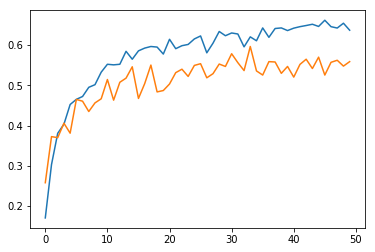

In [101]:
import matplotlib.pyplot as plt

plt.plot(list(range(len(acc_train))), acc_train, acc_test)
plt.show()